In [2]:
import pandas as pd
import re
import spacy
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
# Load the scraped data
df = pd.read_csv('anfragen_oldenburg_detailed.csv', encoding='utf-8')

# Preprocessing Data

In [4]:
# lowercasing
df['Beschreibung'] = df['Beschreibung'].str.lower()

# removal of punctuation and digits
def clean_entries(entry):
    entry = re.sub(r'[\d]', ' ', entry) # remove digits
    entry = re.sub(r'[^\w\s]', ' ', entry) # remove non-word characters
    return entry
df['Beschreibung'] = df['Beschreibung'].apply(clean_entries)

# removal of stopwords (e.g., der, die, das, ein)
nlp = spacy.load("de_core_news_sm")
def remove_stopwords(entry):
    doc = nlp(entry)
    return " ".join([token.text for token in doc if not token.is_stop and not token.is_punct and not token.is_space])
df['Beschreibung'] = df['Beschreibung'].apply(remove_stopwords)

# lemmatization (e.g., reducing gegangen to gehen)
def lemmatize(entry):
    doc = nlp(entry)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space])
df['Beschreibung'] = df['Beschreibung'].apply(lemmatize)

# remove street names
def remove_street_names(entry):
    # remove words ending with straße, strasse, allee, gasse, or weg (except for einweg, which could be trash)
    pattern = r'\b(?!einweg\b)\w*(straße|strasse|str|weg|allee|gasse|nummer|nr)\b'
    return re.sub(pattern, ' ', entry, flags=re.IGNORECASE)
df['Beschreibung'] = df['Beschreibung'].apply(remove_street_names)

# Vectorize

In [25]:
from gensim.models import KeyedVectors

# Tokenize the 'Beschreibung' column
tokenized_descriptions = df['Beschreibung'].apply(lambda x: x.split())

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=2, workers=4, sg=1)


# Get the most frequent words and their vectors
words = w2v_model.wv.index_to_key[:1000]  # adjust number as needed
vectors = [w2v_model.wv[word] for word in words]

# Create document vectors by averaging word vectors for each Beschreibung

def document_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

df['w2v_vector'] = tokenized_descriptions.apply(document_vector)

# Clustering

In [26]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df['w2v_vector'].tolist())

# Cluster-Labels
labels = kmeans.labels_

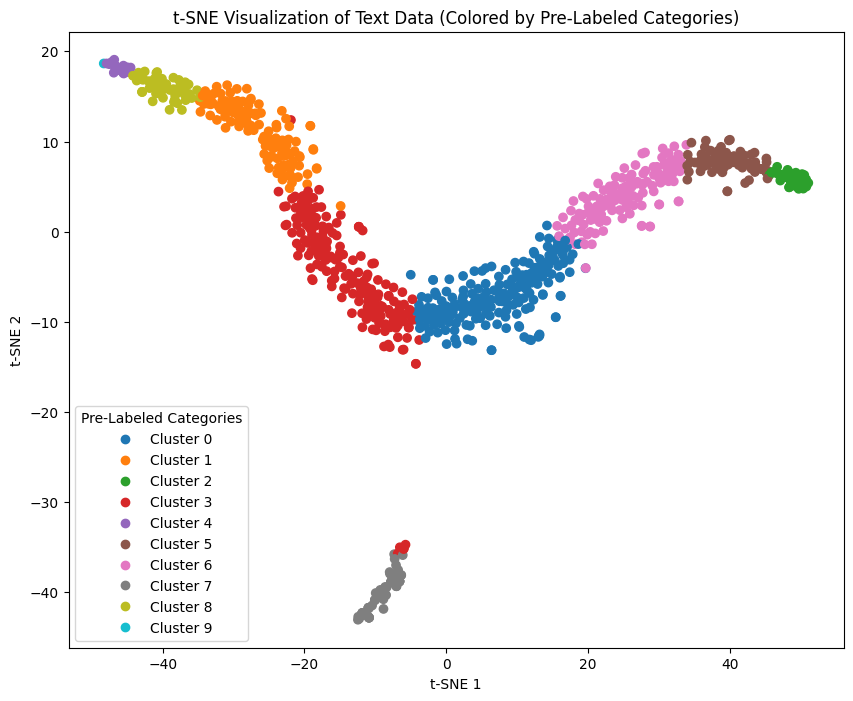

In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Stack vectors into a 2D numpy array
w2v_matrix = np.vstack(df['w2v_vector'].values)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(w2v_matrix)

plt.figure(figsize=(10,8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')

plt.title('t-SNE Visualization of Text Data (Colored by Pre-Labeled Categories)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

legend_labels = [f'Cluster {i}' for i in range(kmeans.n_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Pre-Labeled Categories")

plt.show()

In [28]:
from collections import defaultdict

clustered_words = defaultdict(list)
for word, label in zip(words, labels):
    clustered_words[label].append(word)

# Print sample words from each cluster
for cluster_id, word_list in clustered_words.items():
    print(f"\nCluster {cluster_id}:")
    print(", ".join(word_list[:10]))  # first 10 words in the cluster



Cluster 8:
liegen, vfb, bitte, fahren, abstellen, Fahrzeug, beschädigen, vermutlich, Mülleimer, Karton

Cluster 1:
stehen, Müll, Ecke, mal, Seite, Parkplatz, ca, Spielplatz, Fußgänger, Verkehrszeich

Cluster 3:
Oldenburg, Unterhaltungsfußball, Woche, Richtung, Ampel, Gmbh, Auto, entfernen, gefährlich, graben

Cluster 6:
Aufkleber, Fußball, befinden, wild, schlaglöch, rechts, Foto, Sperrmüll, defekt, alt

Cluster 4:
Höhe, Werbung, entsorgen, Loch, hängen, unten, breit, See, schief, Runter

Cluster 0:
sehen, mehrere, Bereich, Haus, gmbh, Müllkippe, teilweise, Monat, Stelle, Schild

Cluster 2:
strn, Einmündung, direkt, Asphalt, Autobahn, Ca, handeln, verschmutzen, Platz, kennzeichen

Cluster 5:
stark, illegal, Abfall, schön, kommend, gut, Grundstück, mittlerweile, Bemühung, Rad

Cluster 9:
zeigen

Cluster 7:
Kanal, dankbar, per, verletzen, Plastik, unterspült, unbekannt, Erde, p, r
